<a href="https://colab.research.google.com/github/gaditi123/quant/blob/main/MarkowitzCurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install quandl

In [23]:
!pip install yfinance

In [24]:
!pip install nsepy

In [25]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as web
import yfinance as yf
from datetime import date
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [26]:
start = pd.to_datetime('2020-07-25')
end = pd.to_datetime('2021-07-25')

In [27]:
stocks = ['TCS.NS','INFY.NS','TITAN.NS','KOTAKBANK.NS','AXISBANK.NS','DIVISLAB.NS']
data = yf.download(stocks,start=date(2020,7,25),end=date(2021,7,26))

table = data['Adj Close']
table.tail()

[*********************100%***********************]  6 of 6 completed


,AXISBANK.NS,DIVISLAB.NS,INFY.NS,KOTAKBANK.NS,TCS.NS,TITAN.NS
Date,,,,,,
2021-07-16,771.150024,4757.600098,1555.449951,1749.500000,3194.800049,1691.292725
2021-07-19,755.200012,4807.450195,1541.699951,1722.800049,3184.600098,1676.328613
2021-07-20,745.750000,4787.850098,1550.050049,1702.650024,3205.800049,1667.400024
2021-07-22,746.750000,4843.250000,1590.199951,1707.199951,3216.350098,1701.750000
2021-07-23,755.400024,4824.750000,1590.449951,1722.949951,3212.850098,1700.949951


Text(0, 0.5, 'price in Rs')

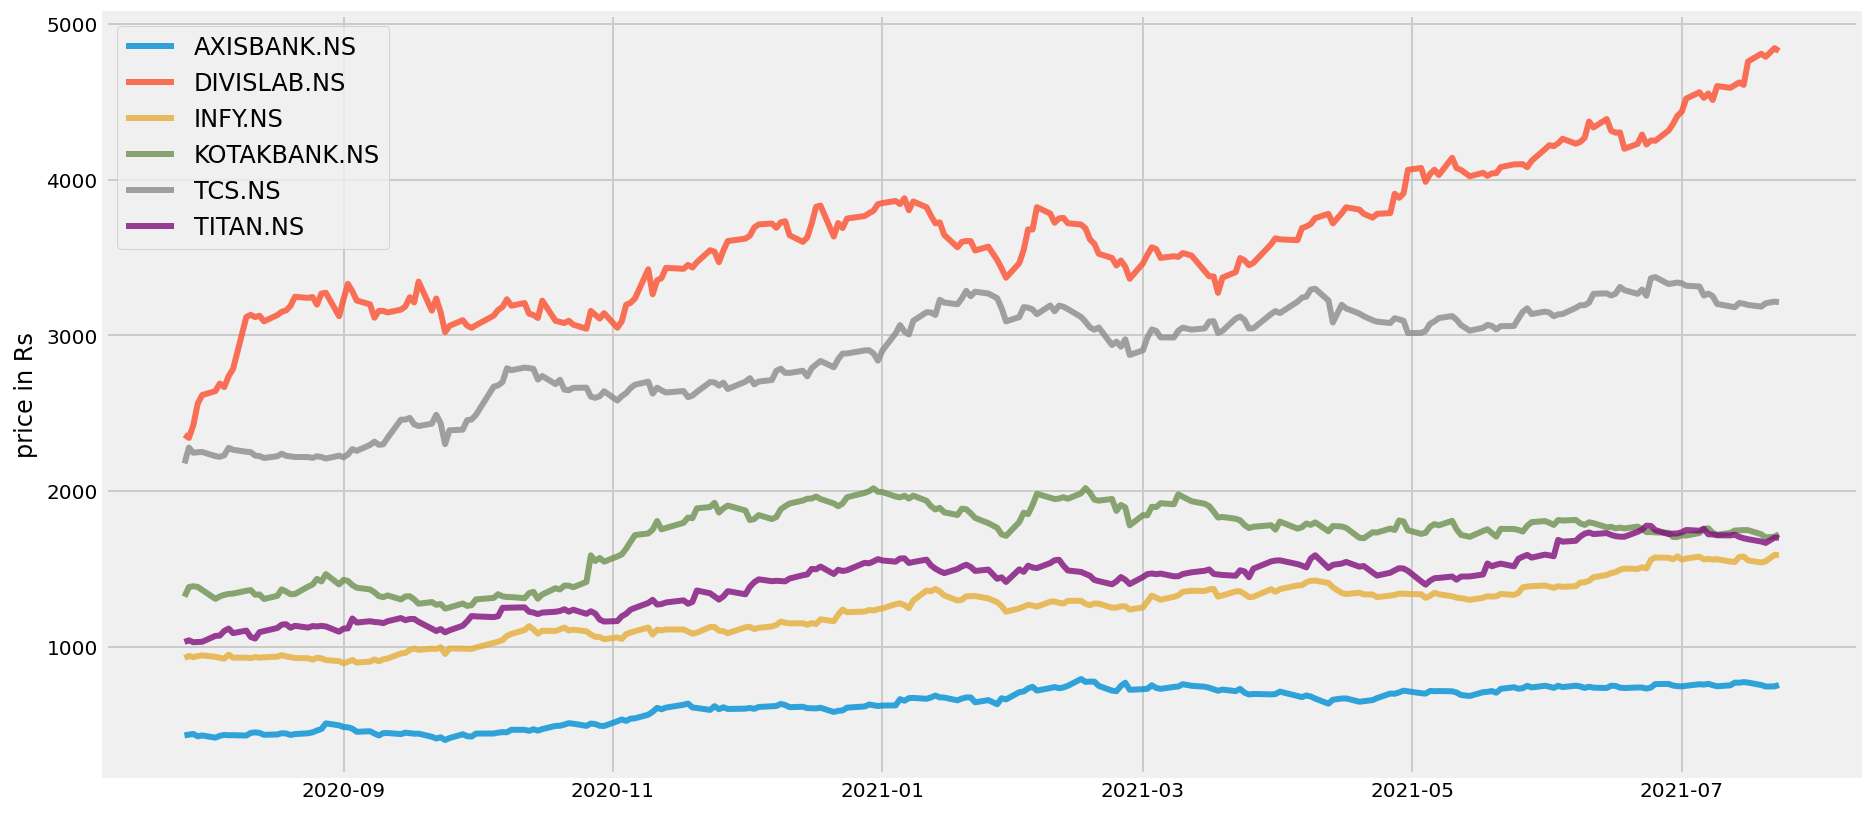

In [28]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in Rs')

We see that TCS and Divis have had a good growth in the last year. The other 4 have mostly had about 500 points increase slowly and a sidewards trend.

Another way to plot this is plotting daily returns (percent change compared to the day before). By plotting daily returns instead of actual prices, we can see the stocks' volatility.

Text(0, 0.5, 'daily returns')

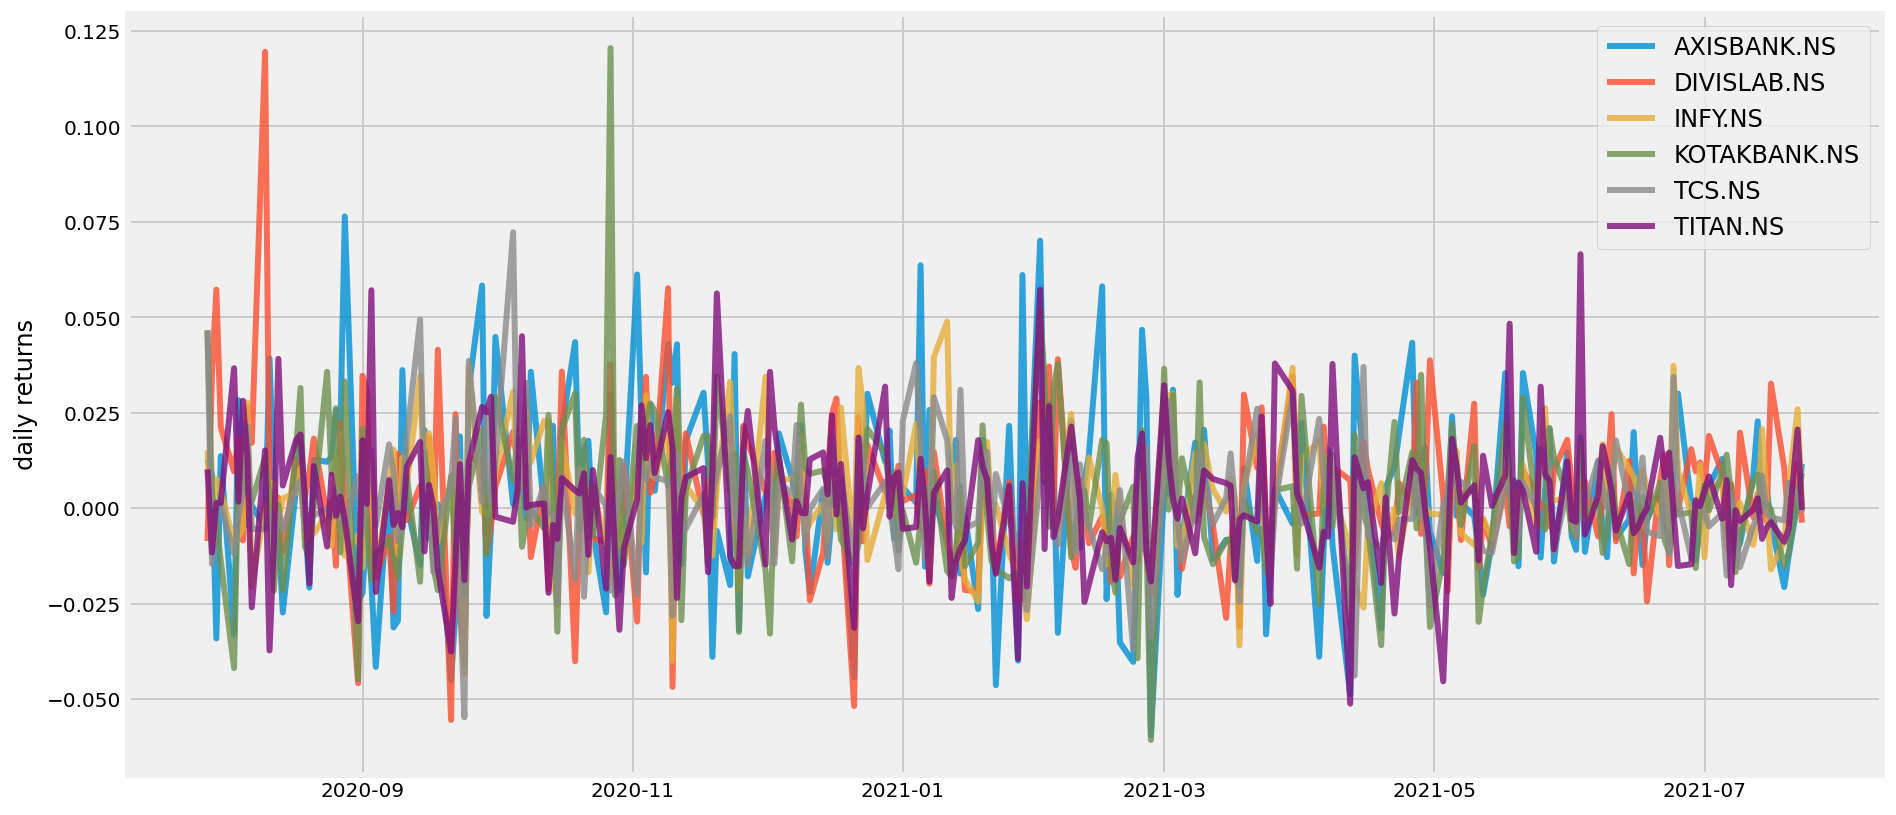

In [29]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

* Divis had a major spike around August'20 and has been more volatile compared to over stocks with higher PCT changes.
* Titan has also has some spikes spread out over the year but mostly a standard trend.
* Axis Bank has has frequent spikes and dips of almost contant magnitude almost acting as resistance and support respectively.
* TCS and INFY are non volatile stocks.
* Kotak Bank has had some major spike before Nov'20 and otherwise remained not much volatile.

# Random Portfolios Generation

"portfolio_annual_performance" function will calculate the returns and volatility, and to make it as an annualised calculation I take into account 252 as the number of trading days in one year. "random_portfolios" function will generate portfolios with random weights assigned to each stock, and by passing num_portfolios argument, you can decide how many random portfolios you want to generate.

In [30]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [31]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((5,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

Got daily returns by calling pct_change on the data frame with the price data. And the mean daily returns, the covariance matrix of returns are needed to calculate portfolio returns and volatility. Finally, generated 30,000 portfolios with random weights assigned to each of the 6 stocks.

In [32]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 30000
risk_free_rate = 0.02

**What the below plot function is doing**

---


First, it generates random portfolio and gets the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weights for the corresponding result. Then by locating the one with the highest Sharpe ratio portfolio, it displays maximum Sharpe ratio portfolio as red star sign. And does similar steps for minimum volatility portfolio, and displays it as the green star on the plot. All the randomly generated portfolios will be also plotted with colour map applied to them based on the Sharpe ratio. The bluer, the higher Sharpe ratio.

And for these two optimal portfolios, it will also show how it allocates the budget within the portfolio.

In [33]:

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='winter', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.64
Annualised Volatility: 0.18


            AXISBANK.NS  DIVISLAB.NS  INFY.NS  KOTAKBANK.NS  TCS.NS  TITAN.NS
allocation        16.95        32.23    33.54          0.05    1.98     15.26
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.51
Annualised Volatility: 0.16


            AXISBANK.NS  DIVISLAB.NS  INFY.NS  KOTAKBANK.NS  TCS.NS  TITAN.NS
allocation         5.93        11.05    24.08         16.93   24.73     17.27


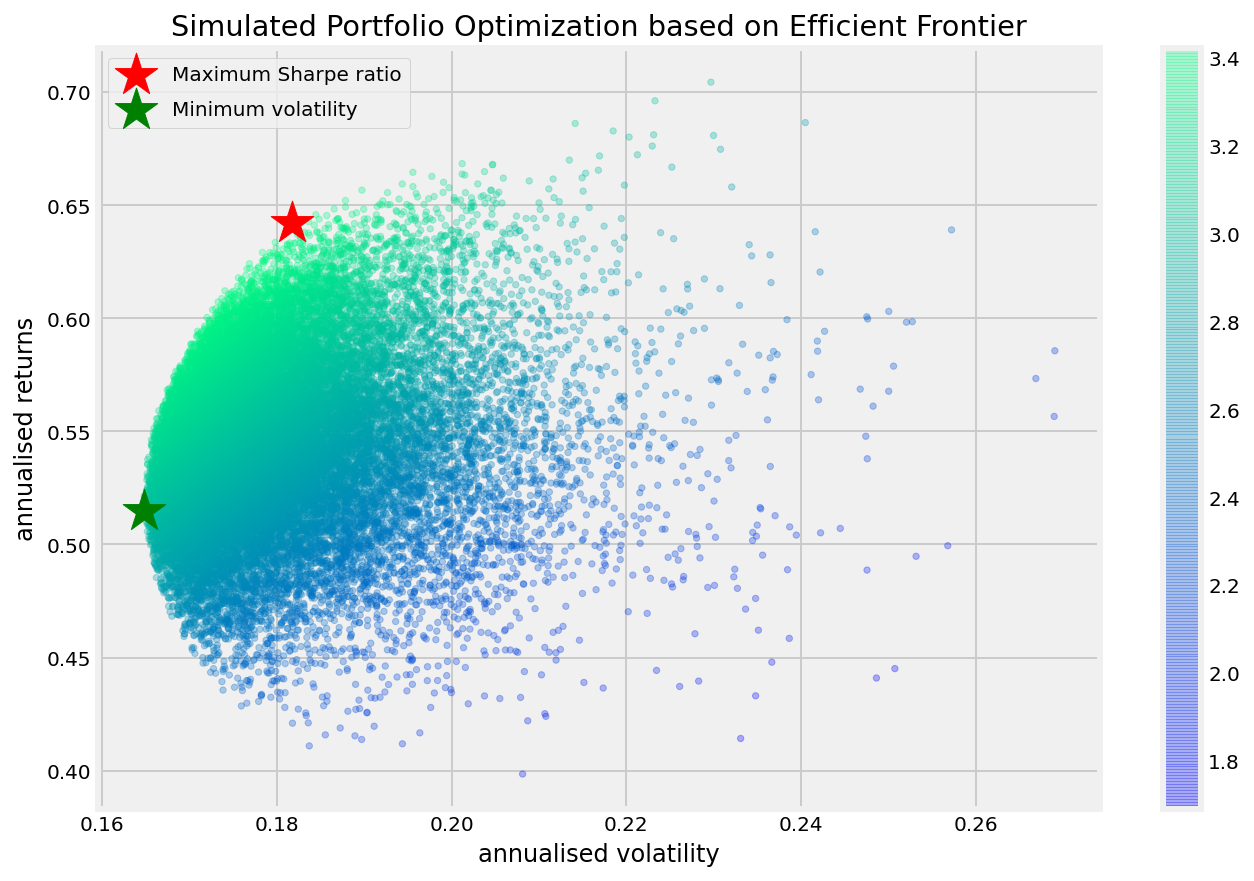

In [34]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Efficient Frontier



From the plot of the randomly simulated portfolio, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called efficient frontier. Why is it efficient? Because points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns. If the expected returns are the same, why would you take an extra risk when there's an option with lower risk?

The way we found the two kinds of optimal portfolio above was by simulating many possible random choices and pick the best ones (either minimum risk or maximum risk-adjusted return). We can also implement this by using Scipy's optimize function.

Below functions are to get the maximum Sharpe ratio portfolio. In Scipy's optimize function, there's no 'maximize', so as an objective function you need to pass something that should be minimized. That is why the first "neg_sharpe_ratio" is computing the negative Sharpe ratio. Now we can use this as our objective function to minimize. In "max_sharpe_ratio" function, you first define arguments (this should not include the variables you would like to change for optimisation, in this case, "weights"). At first, the construction of constraints was a bit difficult for me to understand, due to the way it is stated.

constraints = `({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})`

The above constraint is saying that sum of x should be equal to 1. You can think of the 'fun' part construction as '1' on the right side of equal sign has been moved to the left side of the equal sign.

'`np.sum(x) == 1`' has become '`np.sum(x)-1`'

And what does this mean? It simply means that the sum of all the weights should be equal to 1. You cannot allocate more than 100% of your budget in total.

"bounds" is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

In [35]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

We can also define the optimizing function for calculating minimum volatility portfolio. This time we really do minimize the objective function. What do we want to minimize? We want to minimize volatility by trying different weights. "constraints" and "bounds" are same as the above

In [36]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

As I already mentioned above we can also draw a line which depicts where the efficient portfolios for a given risk rate should be. This is called "efficient frontier". Below I define other functions to compute efficient frontier. The first function "efficient_return" is calculating the most efficient portfolio for a given target return, and the second function "efficient_frontier" will take a range of target returns and compute efficient portfolio for each return level.

In [37]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Let's try to plot the portfolio choice with maximum Sharpe ratio and minimum volatility also with all the randomly generated portfolios. But this time we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy's 'minimize' function. And the below function will also plot the efficient frontier line.

In [38]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.64
Annualised Volatility: 0.18


            AXISBANK.NS  DIVISLAB.NS  INFY.NS  KOTAKBANK.NS  TCS.NS  TITAN.NS
allocation        13.69        31.48    37.42           0.0    0.64     16.77
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.52
Annualised Volatility: 0.16


            AXISBANK.NS  DIVISLAB.NS  INFY.NS  KOTAKBANK.NS  TCS.NS  TITAN.NS
allocation         5.81        12.76    23.18         16.26   24.18     17.81
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AXISBANK.NS : annuaised return 0.64 , annualised volatility: 0.36
DIVISLAB.NS : annuaised return 0.77 , annualised volatility: 0.3
INFY.NS : annuaised return 0.58 , annualised volatility: 0.23
KOTAKBANK.NS : annu

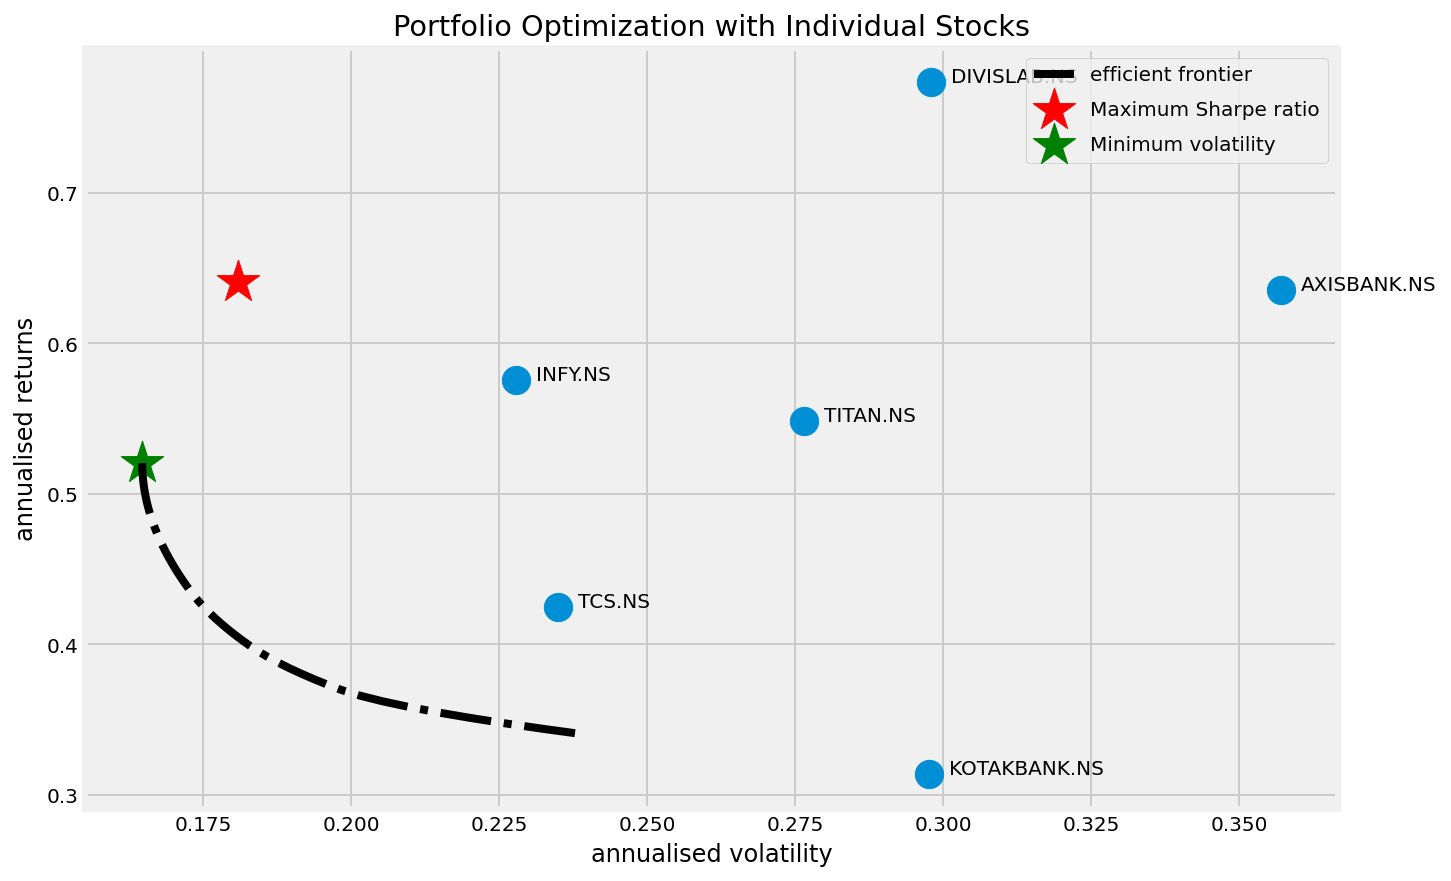

In [39]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)